## LDA for 2022 Data


In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
import pandas as pd
df = pd.read_csv('preprocessed_data.csv')
data_2022 = df[df["Year"]==2022]
data_2022.to_csv('data_2022.csv', index=False)
df_2022= pd.read_csv('data_2022.csv')
df_2022.head(3)

,listing_id,id,date,reviewer_id,comments,SentenceLength,Year,detect,comments_token,comments_string
0,13913,597622110054753727,2022-04-04,2941217,if the room is available just take it !,40,2022,en,"['room', 'available', 'take']",room available take
1,13913,628812668788849576,2022-05-17,32486646,alinas flat is lovely and quirky with art all ...,757,2022,en,"['alinas', 'flat', 'lovely', 'quirky', 'art', ...",alinas flat lovely quirky art around makes lov...
2,13913,631032182017371215,2022-05-20,203803703,this is the most cosy and beautifully-decorate...,199,2022,en,"['cosy', 'beautifully', 'decorated', 'flat', '...",cosy beautifully decorated flat lovely area al...


In [3]:
from tqdm import tqdm_notebook
tqdm_notebook().pandas()

0it [00:00, ?it/s]

In [4]:
# Tokenise comments 

from nltk.tokenize import sent_tokenize
df_2022['sentences'] = df_2022.comments.progress_map(sent_tokenize)
df_2022['sentences'].head(1).tolist()[0][:3] 

  0%|          | 0/108926 [00:00<?, ?it/s]

['if the room is available just take it !']

In [5]:
# Tokenise Sentences

from nltk.tokenize import word_tokenize
df_2022['tokens_sentences'] = df_2022['sentences'].progress_map(lambda sentences: [word_tokenize(sentence) for sentence in sentences])
print(df_2022['tokens_sentences'].head(1).tolist()[0][:3])

  0%|          | 0/108926 [00:00<?, ?it/s]

[['if', 'the', 'room', 'is', 'available', 'just', 'take', 'it', '!']]


In [6]:
# Parts of speech POS tagging lemmanisation

from nltk import pos_tag

df_2022['POS_tokens'] = df_2022['tokens_sentences'].progress_map(lambda tokens_sentences: [pos_tag(tokens) for tokens in tokens_sentences])
print(df_2022['POS_tokens'].head(1).tolist()[0][:3])

  0%|          | 0/108926 [00:00<?, ?it/s]

[[('if', 'IN'), ('the', 'DT'), ('room', 'NN'), ('is', 'VBZ'), ('available', 'JJ'), ('just', 'RB'), ('take', 'VBP'), ('it', 'PRP'), ('!', '.')]]


In [7]:
# Lemmanisation

from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [8]:
# Lemmanisation with Parts of speech tagging per sentence 


df_2022['tokens_sentences_lemmatized'] = df_2022['POS_tokens'].progress_map(
    lambda list_tokens_POS: [
        [
            lemmatizer.lemmatize(el[0], get_wordnet_pos(el[1])) 
            if get_wordnet_pos(el[1]) != '' else el[0] for el in tokens_POS
        ] 
        for tokens_POS in list_tokens_POS
    ]
)

  0%|          | 0/108926 [00:00<?, ?it/s]

In [9]:
df_2022['tokens_sentences_lemmatized'].head(1).tolist()[0][:3]

[['if', 'the', 'room', 'be', 'available', 'just', 'take', 'it', '!']]

In [11]:
#  Grouping  tokens  and removing  stop words 

import nltk


from nltk.corpus import stopwords
stopwords_other = ['though', 'stay', 'would', 'really', 'one', 'could', 'place stay', 'get', 'thank', 'claudia', 'want', 'know', 'use', 'go', 'everything', 'give', 'make', 'us', 'also', 'ever', 'need', 'however', 'say', 'even']

my_stopwords = nltk.corpus.stopwords.words("english") + stopwords_other

In [12]:
from itertools import chain 

In [13]:
df_2022['tokens'] = df_2022['tokens_sentences_lemmatized'].map(lambda sentences: list(chain.from_iterable(sentences)))
df_2022['tokens'] = df_2022['tokens'].map(lambda tokens: [token.lower() for token in tokens if token.isalpha() 
                                                    and token.lower() not in my_stopwords and len(token)>1])

In [14]:
df_2022['tokens'].head(1).tolist()[0][:30]

['room', 'available', 'take']

In [15]:
# LDA  Bigrams and Trigrams 

from gensim.models import Phrases

tokens = df_2022['tokens'].tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

In [16]:
# LDA Corpus 

from gensim import corpora
dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]

In [17]:
# LDA model

from gensim import models
import numpy as np

np.random.seed(123000)
num_topics = 10
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

CPU times: user 2min 34s, sys: 1.4 s, total: 2min 35s
Wall time: 2min 40s


In [18]:
# LDA model topics

for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=15):
    print(str(i)+": "+ topic)
    print()

0: 0.078*"apartment" + 0.035*"good" + 0.027*"flat" + 0.020*"nice" + 0.020*"location" + 0.018*"small" + 0.016*"bedroom" + 0.016*"kitchen" + 0.014*"clean" + 0.014*"building" + 0.012*"bathroom" + 0.010*"expect" + 0.009*"large" + 0.009*"unit" + 0.009*"area"

1: 0.176*"host" + 0.021*"help" + 0.020*"check" + 0.020*"helpful" + 0.014*"kind" + 0.014*"time" + 0.013*"airbnb" + 0.012*"provide" + 0.011*"always" + 0.010*"communicative" + 0.010*"flat" + 0.009*"accommodate" + 0.009*"ask" + 0.009*"extremely" + 0.008*"meet"

2: 0.091*"london" + 0.076*"place" + 0.039*"perfect" + 0.020*"best" + 0.019*"definitely" + 0.016*"city" + 0.013*"trip" + 0.012*"around" + 0.012*"travel" + 0.011*"location" + 0.011*"short" + 0.011*"visit" + 0.010*"time" + 0.010*"accommodation" + 0.010*"look"

3: 0.057*"host" + 0.040*"home" + 0.035*"place" + 0.034*"lovely" + 0.025*"beautiful" + 0.020*"house" + 0.019*"wonderful" + 0.017*"love" + 0.016*"amazing" + 0.013*"comfortable" + 0.012*"perfect" + 0.012*"london" + 0.011*"highly_rec

In [19]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

topics_document_to_dataframe([(9, 0.03853655432967504), (15, 0.09130117862212643), (18, 0.8692868808484044)], 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.038537,NaN,NaN,NaN,NaN,NaN,0.091301,NaN,NaN,0.869287,NaN


In [20]:
topics = [lda_model[corpus[i]] for i in range(len(df_2022))]

In [21]:
# Documents = rows. Topics = columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

document_topic.head()

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.970967,0.0,0.0,0.000000
1,0.047950,0.082114,0.000000,0.339639,0.0,0.496063,0.033146,0.0,0.0,0.000000
2,0.000000,0.000000,0.201033,0.768808,0.0,0.000000,0.000000,0.0,0.0,0.023229
3,0.000000,0.101676,0.000000,0.326512,0.0,0.567175,0.000000,0.0,0.0,0.000000
4,0.148444,0.434692,0.087215,0.100822,0.0,0.164865,0.000000,0.0,0.0,0.063193


In [22]:
# Determining topics in first review 

lda_model[corpus[0]] 

[(6, 0.9709668)]

In [23]:
# discover which reviews are about topic 3

document_topic.sort_values(3, ascending=False)[9].head(20)

85892     0.0
4112      0.0
35762     0.0
5153      0.0
64199     0.0
76509     0.0
81713     0.0
89500     0.0
9231      0.0
84596     0.0
49635     0.0
67609     0.0
11218     0.0
108559    0.0
93849     0.0
107523    0.0
9183      0.0
34273     0.0
30160     0.0
35152     0.0
Name: 9, dtype: float64

<AxesSubplot:>

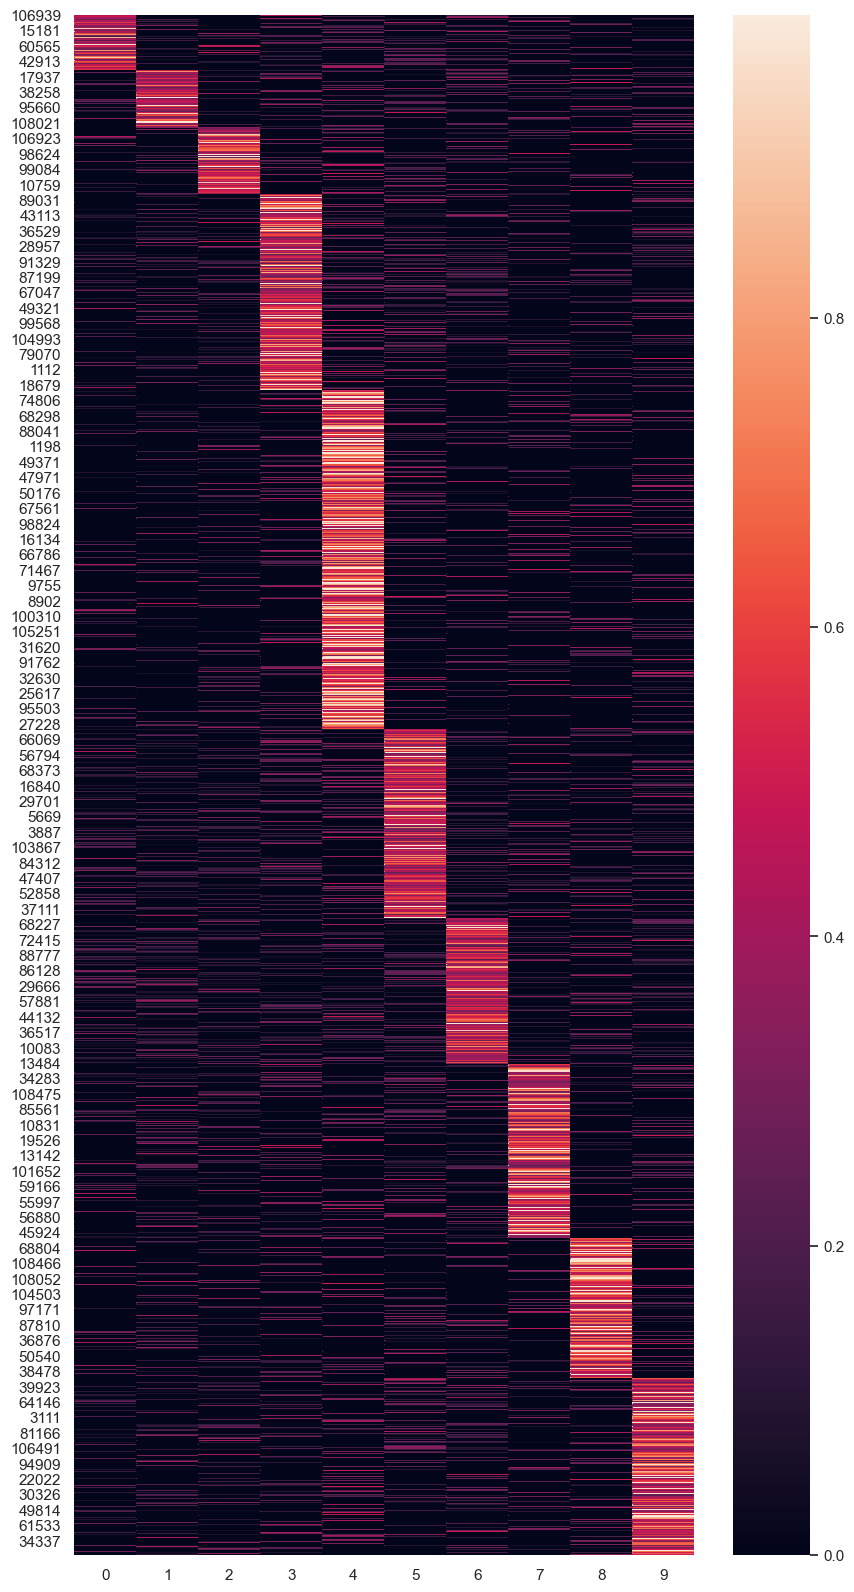

In [24]:
# Heat map showing distribution of topics in all reviews 

%matplotlib inline
import seaborn as sns; sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index])

/Users/lucywalker/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/lucywalker/opt/anaconda3/lib/python3.8/site-packages/seaborn/rcmod.py:402: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/lucywalker/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


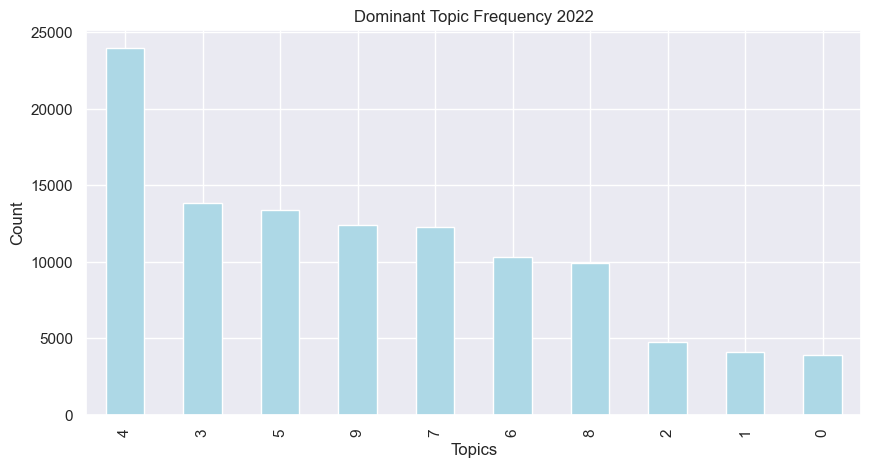

In [28]:
# Graph showing topic distribution in reviews 

import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(10,5)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue')

plt.xlabel('Topics')
plt.ylabel('Count')
plt.title('Dominant Topic Frequency 2022')
plt.show()

In [26]:
# Visualising topics using interactive map

# https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf
# Here a short legend to explain the vis:
# size of bubble: proportional to the proportions of the topics across the N total tokens in the corpus
# red bars: estimated number of times a given term was generated by a given topic
# blue bars: overall frequency of each term in the corpus
# -- Relevance of words is computed with a parameter lambda
# -- Lambda optimal value ~0.6 (https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)